# Kaggle's M5 forecasting Competition

Author: `Armando Miguel Trejo Marrufo`

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import warnings
import missingno as msno 
import seaborn as sns 
import plotly.graph_objects as go
from sklearn.utils import shuffle
from scipy.stats import yeojohnson, yeojohnson_normplot, probplot
warnings.filterwarnings("ignore")

# Display all columns
pd.set_option('display.max_columns', None)

# Use a ggplot style for graphics
plt.style.use('ggplot')

C:\Users\amtre\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


***Notes***

1. ```dt_complementary``` merges the original calendar and price data to know the ```date``` when the ```product_id``` of the ```store_id``` was saled at. Additionaly to know if they were particular events like ```SNAP``` purchases or major events, check the documentation.

2. ```dt_sales_s```. In case you don't have enough RAM take initial n rows of the original dataframe and shuffle the data, because it is ordered.

3. ```dt_sales_melt```. Melt the dataframe so that each sale by product can be seen as row.

4. ```dt_work```. Merges ```dt_sales_melt``` with ```dt_complementary``` to know for each day of sale the price and relevant events associated to that day.

In [25]:
# Load data
files = ['data/calendar.csv', 'data/sales_train_validation.csv', 'data/sell_prices.csv']
data = [pd.read_csv(f) for f in files]
dt_calendar, dt_sales, dt_prices = data

# Merge calendar and prices
dt_prices = shuffle(dt_prices)
dt_complementary = dt_prices.merge(dt_calendar, how='left', on='wm_yr_wk')
del dt_prices
del dt_calendar

# Shuffle data (it is originally ordered) and take n rows (if you don't have enough RAM)
#dt_sales = shuffle(dt_sales)

### 1. Preprocess Data

***A. Zeros in absolute and percentage terms***

If we plot the distribution of the `sales_day` variable we're going to notice that most of the observations are zero, in fact, even the median is zero. For this reason, we're going to analyse the number of zeros in `dt_sales`, because they could represent noise for forecasting.

Text(0.5, 1.0, 'Distribution of number of zeros by observation')

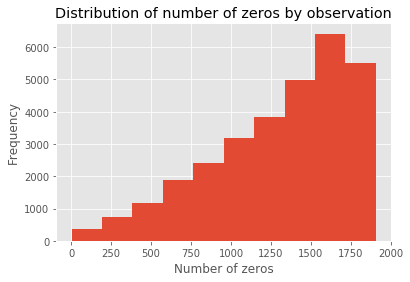

In [26]:
# Count the number of zeros in data 
dt_sales['num_zeros'] = (dt_sales == 0).sum(axis=1)
_ = plt.hist(dt_sales.num_zeros)
plt.xlabel('Number of zeros')
plt.ylabel('Frequency')
plt.title("Distribution of number of zeros by observation")

We see a staggered distribution, that is, as the number of zeros increases so the frequency. But remember that we're not yet considered when does each item started to being sell. For example, a certain product could have zero sell from `d_1` up to `d_1000` because it started to been sold on `d_1001`. Thus, it is unnecessary to consider the information prior to this day for this item. 

Therefore, we're going to obtain the first day of sale form `dt_complementary` and then measure the percentage of zeros by the total number of sale day = `d_1913` - `first_day_of_sale`.

In [28]:
# Transform date variable to datetime
dt_complementary.date = pd.to_datetime(dt_complementary.date)

# Append the first day of sales to each item 
first_date = dt_complementary.groupby(['store_id','item_id']).agg({'date':'min'}).reset_index().rename(columns={'date':'date_first_sale'})
dt_sales = dt_sales.merge(first_date, how='left', on=['store_id','item_id'])

# Difference in days between date_first_sales and d_1
dt_sales['since_d_1'] = dt_sales.date_first_sale - pd.to_datetime('2011-01-29')
dt_sales['since_d_1'] = dt_sales['since_d_1'].apply(lambda x: x.days)

Text(0.5, 1.0, 'Distribution of % of zeros by item')

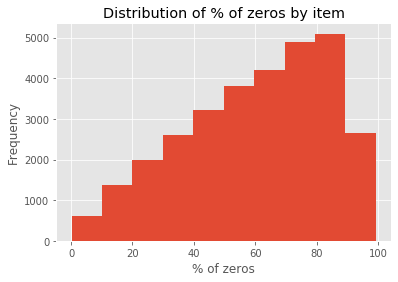

In [57]:
# Percentage of zeros since first day of sale
dt_sales['%_zeros_of_total'] = round(((dt_sales.num_zeros - dt_sales.since_d_1) / (1913 - dt_sales.since_d_1)) * 100, 2)
_ = plt.hist(dt_sales['%_zeros_of_total'])
plt.xlabel('% of zeros')
plt.ylabel('Frequency')
plt.title("Distribution of % of zeros by item")

Based on the graph, we're considering the following bins:

1. `perc_bin_1` --> 0 to 20% zeros.
2. `perc_bin_2` --> 21 to 40% zeros.
3. `perc_bin_3` --> 41 to 60% zeros.
4. `perc_bin_4` --> 61 to 80% zeros.
5. `perc_bin_5` --> 81 to 100% zeros.

In [61]:
def perc_bin(num:int):
    if num <= 20:
        output = 'perc_bin_1'
    elif num <= 40:
        output = 'perc_bin_2'
    elif num <= 60:
        output = 'perc_bin_3'
    elif num <= 80:
        output = 'perc_bin_4'
    else:
        output = 'perc_bin_5'
    return output

dt_sales['perc_zeros_bin'] = dt_sales['%_zeros_of_total'].apply(lambda x: perc_bin(x))

***B. Melt data and dataframe to work***

In [66]:
# Items with less percentage of zeros
dt_sales_bin1 = dt_sales[dt_sales.perc_zeros_bin == 'perc_bin_1'].drop(columns=['id','num_zeros','date_first_sale','since_d_1','%_zeros_of_total','perc_zeros_bin'])
del dt_sales

# Melt sales data
indicators = [f'd_{i}' for i in range(1,1914)]

dt_sales_bin1_melt = pd.melt(dt_sales_bin1, 
                             id_vars = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                             value_vars = indicators, 
                             var_name = 'day_key', 
                             value_name = 'sales_day')
del dt_sales_bin1

dt_sales_bin1_melt['day'] = dt_sales_bin1_melt['day_key'].apply(lambda x: x[2:]).astype(int)

In [71]:
# Data to work with
columns = ['store_id','item_id','sell_price','date','year','d','event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']
dt_work = dt_sales_bin1_melt.merge(dt_complementary[columns], how = 'inner', left_on=['item_id','store_id','day_key'], right_on=['item_id','store_id','d'])
del dt_complementary
print(dt_work.shape)

(3174546, 19)


### 2. Data Imputation

In [75]:
# If there are null values, print the unique values of the column 
for k,v in dict(dt_work.isnull().sum()).items():
    if v > 0:
        print(f"The unique values for the column {k} are:", dt_work[k].unique(), "\n")

The unique values for the column event_name_1 are: [nan 'SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart' 'LentWeek2'
 'StPatricksDay' 'Purim End' 'OrthodoxEaster' 'Pesach End' 'Cinco De Mayo'
 "Mother's day" 'MemorialDay' 'NBAFinalsStart' 'NBAFinalsEnd'
 "Father's day" 'IndependenceDay' 'Ramadan starts' 'Eid al-Fitr'
 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha' 'VeteransDay'
 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear' 'OrthodoxChristmas'
 'MartinLutherKingDay' 'Easter'] 

The unique values for the column event_type_1 are: [nan 'Sporting' 'Cultural' 'National' 'Religious'] 

The unique values for the column event_name_2 are: [nan 'Easter' 'Cinco De Mayo' 'OrthodoxEaster' "Father's day"] 

The unique values for the column event_type_2 are: [nan 'Cultural' 'Religious'] 



We notice that we got missing values for the events, and that this is due to the fact that in that particular day was not tagged as an special event day. Thus, we're simply considering this days as `Normal` and the event type associated with them as `Non-Special`.

In [76]:
dt_work['event_name_1'] = dt_work['event_name_1'].fillna('Normal')
dt_work['event_name_2'] = dt_work['event_name_2'].fillna('Normal')
dt_work['event_type_1'] = dt_work['event_type_1'].fillna('Non-Special')
dt_work['event_type_2'] = dt_work['event_type_2'].fillna('Non-Special')

### 3. Correlation 

In [80]:
# Taken from https://datascience.stackexchange.com/questions/10459/calculation-and-visualization-of-correlation-matrix-with-pandas
corr = dt_work.corr()

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Correlation between variables")\
    .set_precision(2)\
    .set_table_styles(magnify())

,sales_day,day,sell_price,year,snap_CA,snap_TX,snap_WI
sales_day,1.00,-0.06,-0.14,-0.06,0.03,0.03,0.03
day,-0.06,1.00,0.02,0.98,-0.01,-0.00,-0.00
sell_price,-0.14,0.02,1.00,0.02,0.00,0.00,0.00
year,-0.06,0.98,0.02,1.00,0.01,0.01,0.01
snap_CA,0.03,-0.01,0.00,0.01,1.00,0.40,0.40
snap_TX,0.03,-0.00,0.00,0.01,0.40,1.00,0.55
snap_WI,0.03,-0.00,0.00,0.01,0.40,0.55,1.00


Assessing **Multicollinearity** is key, because knowing that one variable could be expressed as a linear combination of other(s), let us avoid the sensity of the coefficient of the model to this phenomenon. 

It is interesting to notice that there is nearly a perfect correlation between `day` and `year`. This is due to the fact that as year increases the day increases, for example, the first 365 observations of the day are for the first year, the next 365 for the second year and so.

### 4. `sales_day` distribution

In [92]:
print(dt_work.sales_day.describe(),
      f"The 1th percentile is {dt_work.sales_day.quantile(.01)}", "\n",
      f"The 5th percentile is {dt_work.sales_day.quantile(.05)}", "\n",
      f"The 10th percentile is {dt_work.sales_day.quantile(.1)}", "\n",
      f"The 15th percentile is {dt_work.sales_day.quantile(.15)}", "\n",
      f"The 20th percentile is {dt_work.sales_day.quantile(.15)}", "\n",
      f"The 90th percentile is {dt_work.sales_day.quantile(.90)}", "\n",
      f"The 98th percentile is {dt_work.sales_day.quantile(.98)}", "\n",
      f"The 99th percentile is {dt_work.sales_day.quantile(.99)}", "\n",
      f"The 99th percentile is {dt_work.sales_day.quantile(.995)}", "\n",
      f"The 99th percentile is {dt_work.sales_day.quantile(.999)}", "\n")

count    3.174546e+06
mean     7.190745e+00
std      1.069146e+01
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      9.000000e+00
max      7.630000e+02
Name: sales_day, dtype: float64 The 1th percentile is 0.0 
 The 5th percentile is 0.0 
 The 10th percentile is 0.0 
 The 15th percentile is 1.0 
 The 20th percentile is 1.0 
 The 90th percentile is 16.0 
 The 98th percentile is 37.0 
 The 99th percentile is 50.0 
 The 99th percentile is 64.0 
 The 99th percentile is 108.0 



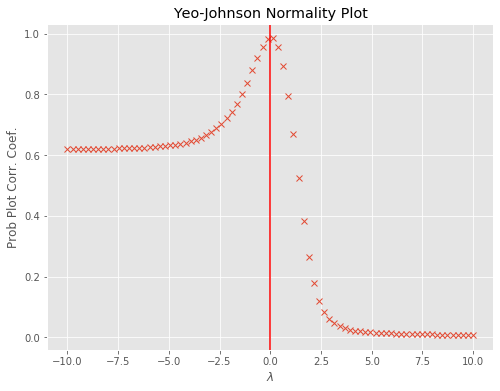

In [101]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Yeo-Johson Normality Plot 
lmbd_yj = yeojohnson_normplot(dt_work.sales_day, -10, 10, plot=ax)
sales_transformed, maxlmbd = yeojohnson(dt_work.sales_day)

ax.axvline(maxlmbd, color='r')
plt.show()

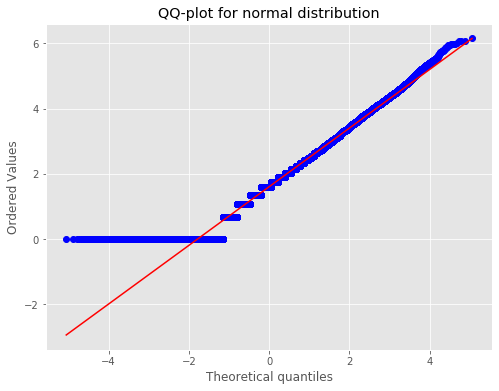

In [102]:
# QQ-plot of sales transformation 
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
qq_plot = probplot(sales_transformed, dist="norm", plot=ax)
ax.set_title("QQ-plot for normal distribution")
plt.show()

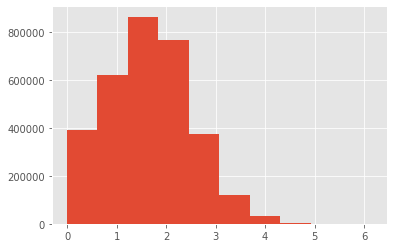

In [103]:
# Histogram of transformed data
_ = plt.hist(sales_transformed)

In [25]:
# Sort data by date
#dt_work_CA = dt_work_CA.sort_values(by=['date'])

# Filter by columns of interest
#cols_to_drop = ['id', 'item_id', 'day_key', 'day', 'date', 'd']
#dt_CA_reg = dt_work_CA.drop(columns=cols_to_drop)

count    498452.000000
mean          1.625328
std           4.283068
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         427.000000
Name: sales_day, dtype: float64